In [9]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)
sns.set(style="darkgrid")
style.use('seaborn-bright')

# TODO
# One hot encoding
# hash encoding
# preprocessing

## Exploring and cleaning the data

In [2]:
df = pd.DataFrame(pd.read_csv('data_for_student_case.csv'))
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290382 entries, 0 to 290381
Data columns (total 17 columns):
txid                            290382 non-null int64
bookingdate                     290382 non-null datetime64[ns]
issuercountrycode               289889 non-null object
txvariantcode                   290382 non-null object
bin                             290242 non-null float64
amount                          290382 non-null float64
currencycode                    290382 non-null object
shoppercountrycode              289900 non-null object
shopperinteraction              290382 non-null object
simple_journal                  290382 non-null object
cardverificationcodesupplied    275665 non-null object
cvcresponsecode                 290382 non-null int64
creationdate                    290382 non-null datetime64[ns]
accountcode                     290382 non-null object
mail_id                         290382 non-null object
ip_id                           290382 non-null 

In [3]:
# Inspect the amount of missing data we have and filter it out
# All of the missing data is categorical, with by far the most values missing in the column 
# cardverificationcodesupplied, a boolean value column

print(f'Total missing values: {df.isnull().values.sum()}\n')
print(f'Missing value distribution: \n{df.isnull().sum()}')

# Drop the missing values
df_unclean = df.copy()

Total missing values: 15832

Missing value distribution: 
txid                                0
bookingdate                         0
issuercountrycode                 493
txvariantcode                       0
bin                               140
amount                              0
currencycode                        0
shoppercountrycode                482
shopperinteraction                  0
simple_journal                      0
cardverificationcodesupplied    14717
cvcresponsecode                     0
creationdate                        0
accountcode                         0
mail_id                             0
ip_id                               0
card_id                             0
dtype: int64


In [4]:
# Printing more info on the columns: possible values that are seen in the dataset
for col in df.columns:
    print(f'Column: {col}')
    print(df[col].unique())
    print(f'length: {len(df[col])}')

Column: txid
[     1      2      3 ... 482732 482733 482734]
length: 290382
Column: bookingdate
['2015-11-09T14:26:51.000000000' '2015-11-09T14:27:38.000000000'
 '2015-11-23T16:34:16.000000000' ... '2015-10-31T22:03:39.000000000'
 '2015-11-02T20:16:57.000000000' '2015-11-03T18:57:01.000000000']
length: 290382
Column: issuercountrycode
['MX' 'US' nan 'BR' 'CA' 'ES' 'CH' 'SA' 'TH' 'SG' 'NL' 'GB' 'IN' 'TW' 'MY'
 'DO' 'CO' 'CL' 'UA' 'AU' 'BE' 'TZ' 'PH' 'IT' 'DE' 'HU' 'KZ' 'GR' 'KE'
 'IL' 'VN' 'NO' 'AR' 'CN' 'HN' 'EG' 'AE' 'BB' 'FR' 'ID' 'BA' 'FI' 'PE'
 'RU' 'HK' 'KR' 'NZ' 'TR' 'IE' 'PK' 'SE' 'RO' 'EC' 'UY' 'BS' 'BH' 'PA'
 'BO' 'DK' 'AZ' 'QA' 'BZ' 'MT' 'LB' 'VE' 'JP' 'SV' 'LK' 'ZA' 'CK' 'LA'
 'KH' 'AT' 'MO' 'FJ' 'RS' 'LU' 'SB' 'JO' 'ZM' 'AO' 'PL' 'NG' 'LT' 'IQ'
 'BG' 'PT' 'GE' 'GI' 'LV' 'KW' 'BM' 'OM' 'CY' 'SK' 'ZZ' 'AL' 'GH' 'MU'
 'MD' 'SL' 'CR' 'BN' 'LY' 'ZW' 'SI' 'IS' 'BY' 'TJ' 'BW' 'MK' 'HR' 'VG'
 'BD' 'EE' 'CW' 'AM' 'AI' 'MN' 'PY' 'TM' 'ME' 'AD' 'GT' 'PR' 'DZ' 'TT'
 'CZ' 'KY' 'CG' 'CM'

### Preprocessing 
We pre-process the dataset to prepare for visualization

- 1 remove Refused transactions
- 2 add amount_converted column with GBP amount
- 3 Add boolean is_fraud column

In [58]:
df = pd.read_csv('preprocess.csv')
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)

In [ ]:
# dont use this !

df = pd.DataFrame(pd.read_csv('data_for_student_case.csv'))
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)
# First remove the refused transactions
df = df[df['simple_journal'] != 'Refused']

# Fill cardverificationcodesupplied NaN values with False
df.cardverificationcodesupplied.fillna(value=False, inplace=True)

def convert_currency(row):
    coversion_dict = {'SEK':0.08766,'MXN':0.04057,'AUD':0.5715,'NZD':0.5327,'GBP':1}
    currency = row['currencycode']
    amount = row['amount']
    return round(amount * coversion_dict[currency])

def fix_countrycodes(row):
    if pd.isnull(row.issuercountrycode):
        row.issuercountrycode = row.shoppercountrycode
    elif pd.isnull(row.shoppercountrycode):
        row.shoppercountrycode = row.issuercountrycode
    return row
    
def changerows(row):
    if row.txid % 50000 == 0:
        print(row)
        
    # Now we add a column to all the data containing the transacted amount in GBP. 
    row['amount_convert'] = convert_currency(row)
    
    # if countrycodes are NaN use the code of the issuer/shoppercountry 
    row = fix_countrycodes(row)
    
    # map cvc response code to 0,1,2,3
    map_cvc = {0:0, 1:1, 2:2, 3:3, 4:3, 5:3, 6:3}
    
    row['cvcresponsecode'] = map_cvc[row['cvcresponsecode']]
    # Add is_fraud column for ease of use
    row['is_fraud'] = row['simple_journal'] == 'Chargeback'
    return row

df = df.apply(changerows, axis=1)
# df['amount_convert'] = df.apply(lambda x: changerows(x), axis=1)
# df_no_refused = df_no_refused.apply(fix_countrycodes, axis=1)

# Should be no more missing values
print(f'Total missing values: {df.isnull().values.sum()}\n')

df.head()

In [74]:
df.to_csv('preprocess.csv')

In [59]:
# convert columns with categorical value to one hot encoded
def cat_to_oneh(dataframe, column, hashsize):
    """
    Function for changing a column with categorical variables into multiple one hot encoded columns using hashes
    """
    
    df1 = df[column].copy()
    print(len(df1))
    df1 = df1.apply(lambda x: str(hash(x))[1:hashsize])
    df1 = pd.DataFrame(df1.str.split('').tolist())
    df1 = df1.drop([0, hashsize], axis=1)
    df1 = pd.get_dummies(df1)
    df1.columns = [column + '_' + x for x in df1.columns]
#     print(df1.tail())
    df1.reset_index(inplace=True)
    return df1

cat_cols = ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode',
                        'shopperinteraction', 'accountcode', 'cvcresponsecode']
col_amounts = [1,0,0,1,0,0,0]
# #bin?? 

df.reset_index(inplace=True)
index = 0
for col in cat_cols:
    if col_amounts[index]:
        df = pd.concat([df, cat_to_oneh(df, col, 6)], axis=1)
    else:
        df = pd.concat([df, pd.get_dummies(df[col])], axis=1)
    index += 1
    df.drop(col, axis=1, inplace=True)
df.rename(columns={0:'cvcresp0', 1:'cvcresp1', 2:'cvcresp2', 3:'cvcresp3'}, inplace=True)    

237036
237036


In [7]:
# Grouping on simple_journal and check mean values to check for differences

df.groupby(df['is_fraud']).mean()

# Fraudulent transactions have generally lower cvc response codes

,index,Unnamed: 0,txid,bin,amount,cardverificationcodesupplied,cvcresponsecode,amount_convert,is_fraud,index,...,Ecommerce,POS,APACAccount,MexicoAccount,SwedenAccount,UKAccount,cvcresp0,cvcresp1,cvcresp2,cvcresp3
is_fraud,,,,,,,,,,,,,,,,,,,,,
False,118651.453405,142224.916731,282356.836572,485026.022493,18888.996037,0.913685,0.816182,6765.743353,0.0,118651.453405,...,0.969462,0.001428,0.114694,0.042253,0.078098,0.764955,0.185271,0.813985,0.000034,0.00071
True,26617.310145,39342.475362,73571.394203,498004.162319,105137.652174,0.930435,0.121739,13068.417391,1.0,26617.310145,...,0.930435,0.000000,0.359420,0.449275,0.086957,0.104348,0.878261,0.121739,0.000000,0.00000


txvariantcode
electron              18
mc                     3
mccredit           50571
mcdebit            12843
visa                1388
visabusiness         300
visaclassic        11089
visacorporate        341
visadebit         147189
visagold            4521
visaplatinum        8434
visapurchasing        40
visasignature        299
Name: txid, dtype: int64


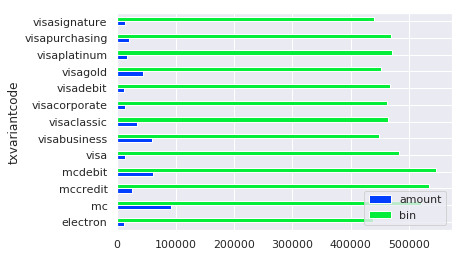

In [10]:
# Count the number of transactions done using the different txvariantcodes
txgroup = df.groupby(by=['txvariantcode'])
tx_avg = txgroup.mean()
tx_count = txgroup.count()

print(tx_count['txid'])

tx_series = tx_count.iloc[:,0]

features_of_interest = pd.DataFrame({'amount': tx_avg['amount'], 'bin': tx_avg['bin']})

features_of_interest.plot(kind='barh')

/usr/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


mean: 
#is_fraud
False     18888.996037
True     105137.652174
Name: amount, dtype: float64

std: 
#is_fraud
False     41342.000541
True     124188.477258
Name: amount, dtype: float64

max amount: 
#is_fraud
False    1955765.0
True      769500.0
Name: amount, dtype: float64



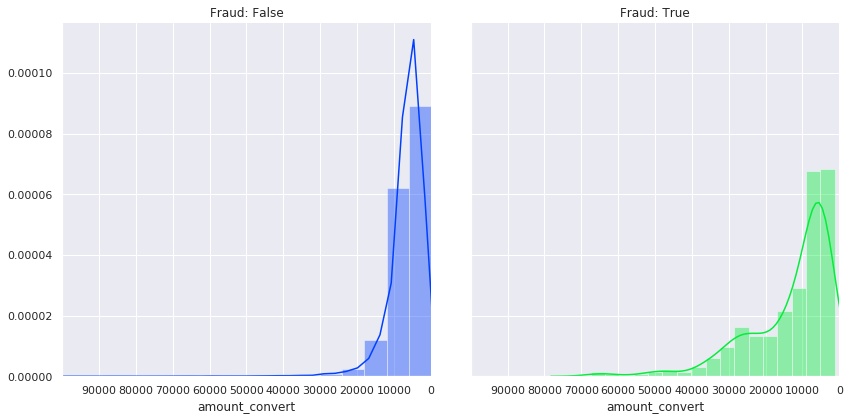

In [11]:
## Visualize fraud vs amounts
g = sns.FacetGrid(df, col="is_fraud", size=6,hue='is_fraud', sharex=True, xlim=100000)
g.map(sns.distplot,"amount_convert", kde=True)
g.set(xticks=range(0,100000, 10000))
g.set_titles('Fraud: {col_name}')

print(f"mean: \n#{df.groupby(by=['is_fraud'])['amount'].mean()}\n")
print(f"std: \n#{df.groupby(by=['is_fraud'])['amount'].std()}\n")
print(f"max amount: \n#{df.groupby(by=['is_fraud'])['amount'].max()}\n")

Form the plots above we can see that the transacted amount for fraud transactions is higher on average than the non fraud ones, and also contain more outliers for the higher amounts.

Looking at the numerical values of the mean and deviation the transacted amounts we see confirmation that the mean amount of fraudulent transactions is much higher than non-fraudulent ones, mainly caused by large outliers.


/usr/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


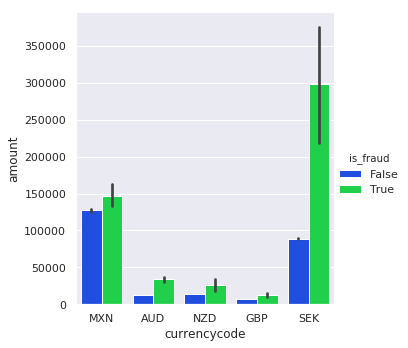

In [12]:

sns.factorplot(data=df, kind='bar', x="currencycode", y="amount", hue="is_fraud")


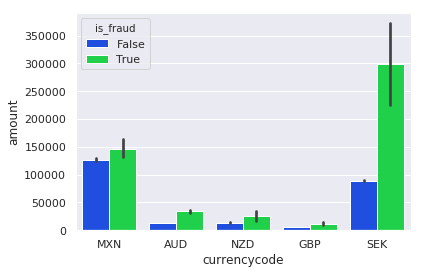

In [13]:
# Bar plot of fraud vs legit transations per currencycode
sns.barplot(data=df, x="currencycode", y="amount", hue="is_fraud")

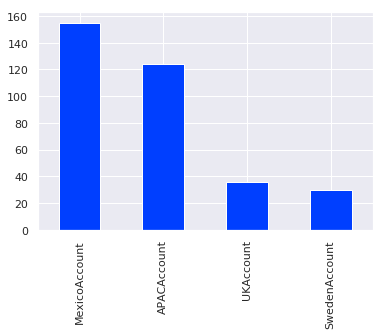

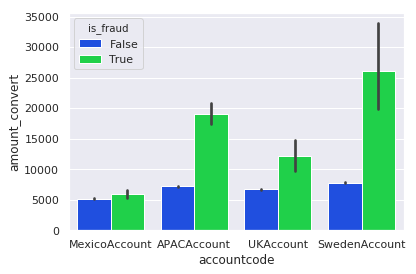

In [14]:
# Amount of fraudulent tranactions per account code
# MexicoAccount has by far the most fraudulent transations, but the amounts are much lower per fraudulent transaction.
# SwedenAccount has the lowest number of fraudulent txs, but the amount of money involved is the highest
fraudulent = df[df["is_fraud"] == 1]
plt.figure()
fraudulent['accountcode'].value_counts().plot(kind='bar')
plt.figure()
sns.barplot(data=df, x="accountcode", y="amount_convert", hue="is_fraud")

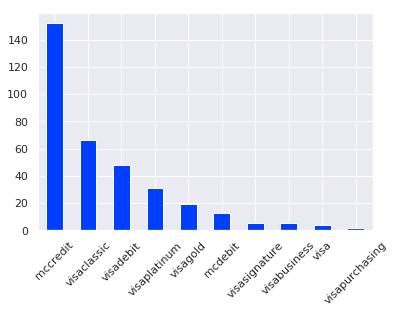

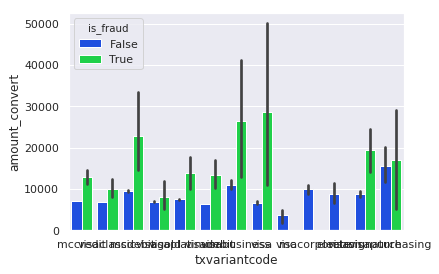

In [15]:
# same visualisation as above but with txvariantcode.
# Mccredit has the highest num of fraud tx but not the highest amount, although there are some with way less
plt.figure()
fraudulent['txvariantcode'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.figure()
sns.barplot(data=df, x="txvariantcode", y="amount_convert", hue="is_fraud")

<Figure size 432x288 with 0 Axes>

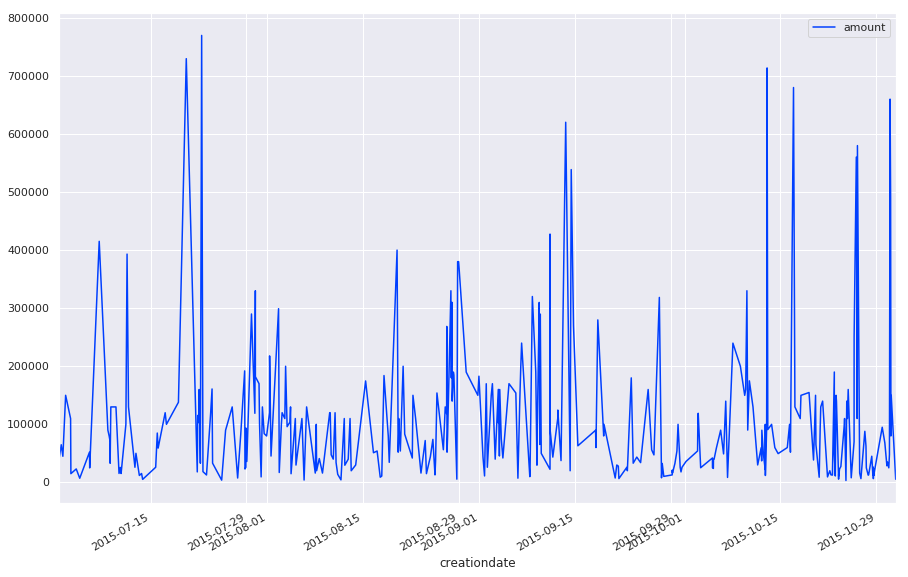

In [16]:
# Amount of fraud over time shows a very small decline in the amount of fraud committed over time.
fraudulent = df[df["is_fraud"] == 1]
len(fraudulent)

# attempt 1
# sns.lineplot(x="bookingdate", y="amount", data=fraudulent.sort_index(by='bookingdate'))

#attempt 2
# fraudulent.set_index("bookingdate").groupby(pd.Grouper(freq='M')).head()
# plt = sns.lineplot(x="creationdate", y="amount", data=gr)
# plt.xticks(rotation=70)

#attempt 3
plt.figure();
fraudulent.set_index("creationdate").plot(figsize=(15,10), y='amount')

In [17]:
# amount of fraud per month of the year, no idea how to make a bar plot of this..
fraudulent = df[df["is_fraud"] == 1]
monthly = fraudulent['amount'].groupby(df['bookingdate'].dt.month).mean()

monthly = df.groupby(df['bookingdate'].dt.month).mean()


/usr/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


spent_in_issue_country  is_fraud
False                   False         6531
                        True            14
True                    False       230160
                        True           331
Name: is_fraud, dtype: int64


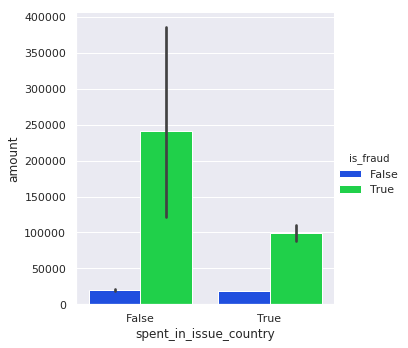

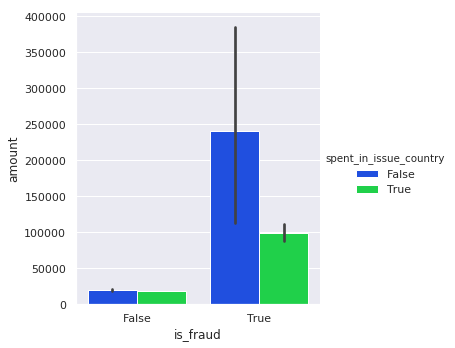

In [18]:
# Attempting to explore is theres a higher chance of fraud when issuercountrycode != shoppercountrycode

is_equal = df[df['issuercountrycode'] == df['shoppercountrycode']]
not_equal = df[df['issuercountrycode'] != df['shoppercountrycode']]

spent_in_issue_country = df['issuercountrycode'] == df['shoppercountrycode']
df['spent_in_issue_country'] = spent_in_issue_country
# sns.barplot(data=is_equal, x="currencycode", y="amount", hue="is_fraud")
# sns.barplot(data=df, x="currencycode", y="amount", hue="is_fraud")

# is_equal['is_fraud']
# fig1, ax1 = plt.subplots()
# ax1.pie(is_equal['is_fraud'], labels=['is fraud', 'is not fraud'], autopct='%1.1f%%', shadow=True)
# ax1.axis('equal')
# plt.show()
# df.plot(kind='pie', y='amount')

sns.factorplot(data=df, kind='bar', x="spent_in_issue_country", y="amount", hue="is_fraud")
sns.factorplot(data=df, kind='bar', x="is_fraud", y="amount", hue="spent_in_issue_country")

group = df.groupby(["spent_in_issue_country", "is_fraud"])["is_fraud"].count()
# group[0].plot.bar(title="spent_in_issue_country=False")
# group[1].plot.bar(title="spent_in_issue_country=True")

# group[0].plot.pie(subplots=True)
print(group)

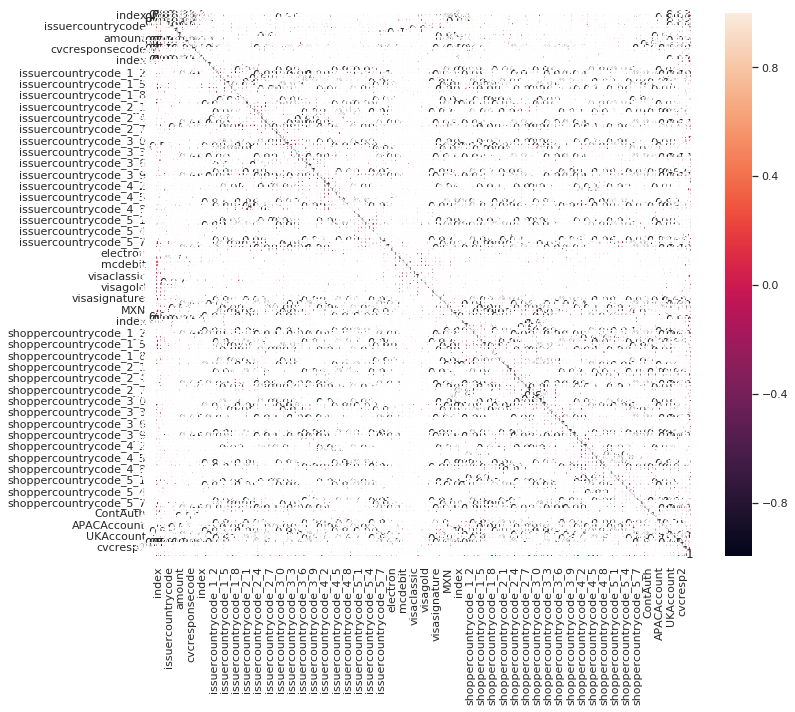

In [19]:
# Heatmap, only numerical data is taken into account, 
# may need to encode some data to add exra columns <- may cause wrong correlations?
# is_fraud appears to have extremely low correlation with all other columns, 
# especially the column of interest 'is_fraud'

def create_list_mapping(somelist):
    # takes a list eg ["A", "B"] and maps it to a dict eq {"A": 0, "B": 1}
    return {x:somelist.tolist().index(x) for x in somelist}

issuercountrycode_map = create_list_mapping(df['issuercountrycode'].unique())
txvariantcode_map = create_list_mapping(df['txvariantcode'].unique())
currencycode_map = create_list_mapping(df['currencycode'].unique())

df_remapped = df.replace(issuercountrycode_map)
df_remapped = df_remapped.replace(txvariantcode_map)
df_remapped = df_remapped.replace(currencycode_map)

plt.figure(figsize=(12,10))
sns.heatmap(df_remapped.corr(), annot=True)

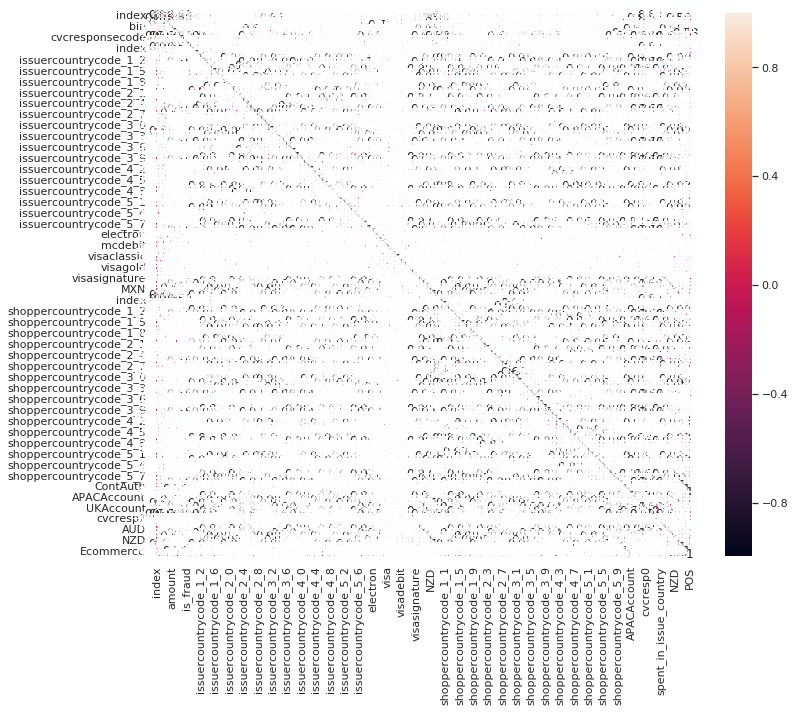

In [20]:
## Heatmap with onehotencoding
df_onehot = df.copy()
df_onehot.head()
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(df['currencycode'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
df_onehot = pd.concat([df_onehot, lb_results_df], axis=1)

lb_results = lb.fit_transform(df['shopperinteraction'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
df_onehot = pd.concat([df_onehot, lb_results_df], axis=1)

plt.figure(figsize=(12,10))
sns.heatmap(df_onehot.corr(), annot=True)

In [25]:
def cat_to_oneh(dataframe, column):
    df1 = dataframe.copy()
    df1 = df[column]
    df1 = df1.apply(lambda x: str(hash(x))[1:10])
    df1 = pd.DataFrame(df1.str.split('',).tolist())
    df1 = df1.drop([0,10], axis=1)
    return pd.get_dummies(df1)

In [26]:
dftest = cat_to_oneh(df, 'txvariantcode')

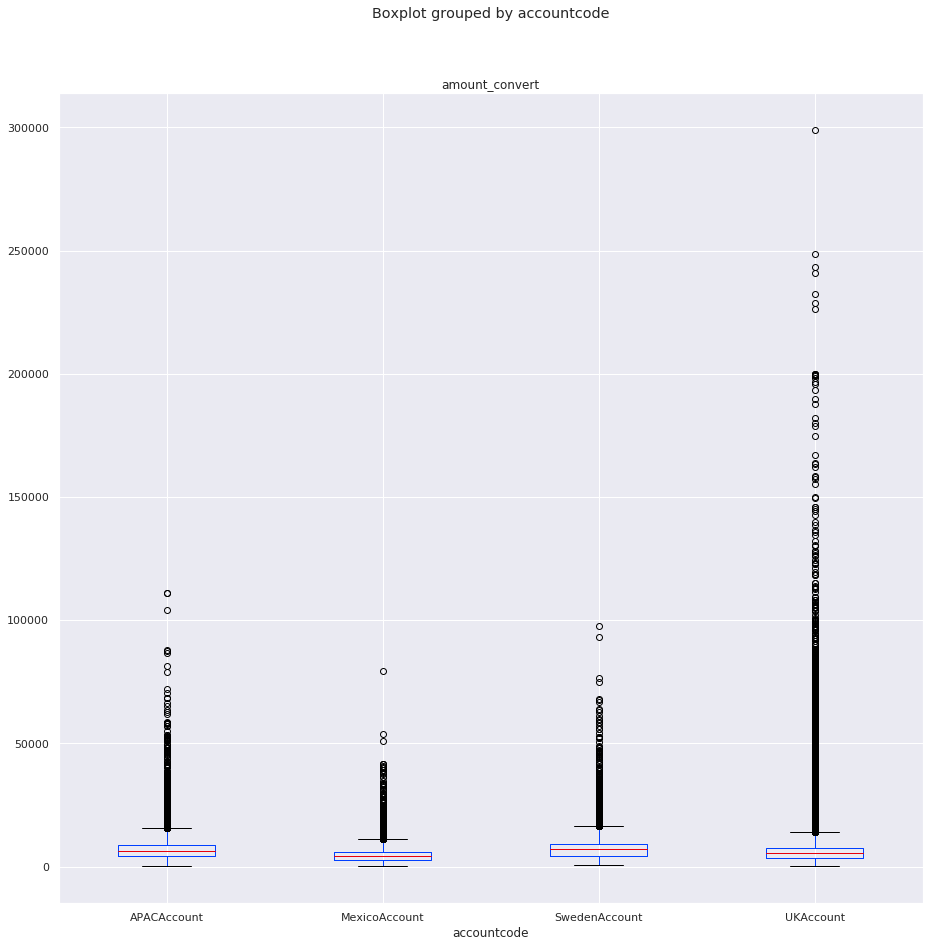

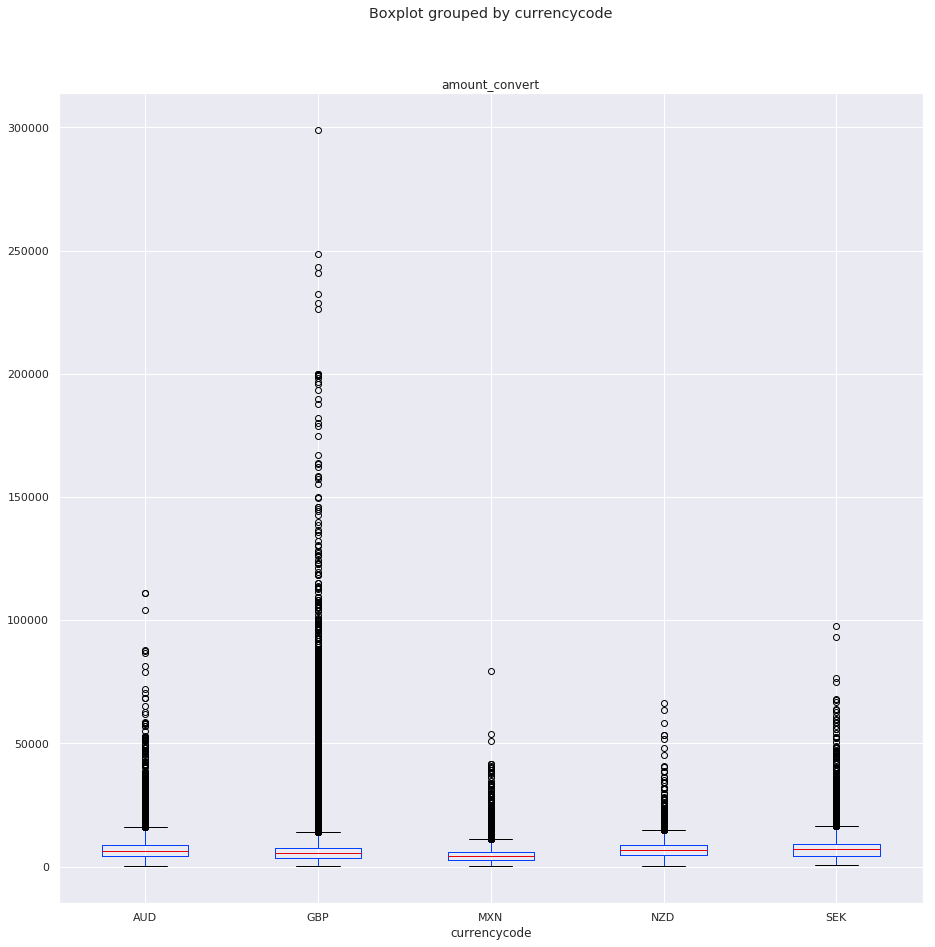

In [27]:
df.boxplot('amount_convert', 'accountcode', figsize=(15,15))
df.boxplot('amount_convert', 'currencycode', figsize=(15,15))

In [28]:
# No card verification code supplied has no cases of fraud,
df_unclean['hascardverification'] = df_unclean['cardverificationcodesupplied'].apply(lambda x: isinstance(x, int))
sns.factorplot(data=df_unclean, kind='bar', x="hascardverification", y="amount", hue='is_fraud')

df_unclean.groupby([df_unclean['hascardverification'], df['is_fraud']]).count()

ValueError: Could not interpret input 'is_fraud'

## Imbalance Task
Process the data such that you can apply SMOTE to it. SMOTE is included in most analysis platforms, if not you can write the scripts for it yourself. Analyze the performance of at least three classifiers on the SMOTEd and UNSMOTEd data using ROC analysis. Provide the obtained ROC curves and explain which method performs best. Is using SMOTE a good idea? Why (not)

Classifiers:
- Random Forest
- Logistic Regression 
- Support Vector Machine

In [29]:
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression

data = pd.read_csv('data.csv')  # load data set
X = data.iloc[:, 0].values.reshape(-1, 1)  # values converts it into a numpy array
Y = data.iloc[:, 1].values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X) # make predictions

FileNotFoundError: [Errno 2] File b'data.csv' does not exist: b'data.csv'

## Smote

In [76]:
# Applying smote
from imblearn.over_sampling import SMOTE

def apply_smote(columns, data, fraud_rows):
#     print(data['is_fraud'].value_counts())

    smt = SMOTE(random_state=0)
    X_train, y_train = smt.fit_sample(data[columns], fraud_rows)

    print(np.bincount(y_train))
    
    return X_train, y_train 


## Spliting into test and training set

In [31]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

def split_data(x, y):
    values_to_predict = np.array(y)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(
        x, values_to_predict, test_size = 0.25, random_state = 42)
    
    return train_features, test_features, train_labels, test_labels

## Random Forrest

In [32]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

def random_forrest(train_features, test_features, train_labels, test_labels):
    # Instantiate model with 100 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    # Train the model on training data
    rf.fit(train_features, train_labels);
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    return predictions, errors

In [33]:
def plot_roc_curve(fpr, tpr):  
    plt.figure(figsize=(12,8), dpi=300)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    return plt

In [91]:
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score  

nummerical_cols = ['amount_convert', 
                   'currencycode', 
                   'spent_in_issue_country', 
                   'cvcresponsecode', 'txvariantcode']

fraud_rows = df['is_fraud']
df_exp = df.drop(["bookingdate", 
                  "creationdate", 
                  "simple_journal", 
                  "mail_id", 
                  "ip_id", 
                  "card_id",
                  "is_fraud",
                  "txid",
                  "index",
                  "Unnamed: 0"], axis = 1)

cols = list(df_exp.columns)
print(cols)
# apply smote and splitting
# train_features, test_features, train_labels, test_labels = split_data(X_train, y_train)
train_features, test_features, train_labels, test_labels = split_data(df_exp, df['is_fraud'])
X_train, y_train = apply_smote(cols, train_features, train_labels)
predictions, errors = random_forrest(X_train, test_features, y_train, test_labels)

auc = roc_auc_score(test_labels, predictions)  
print('AUC: %.2f' % auc)  
fpr, tpr, thresholds = roc_curve(test_labels, predictions)  

i = 0
false_negs = 0
false_pos = 0
true_pos
for p in predictions:
    if (p < 0.5 and test_labels[i]):
#         print(f"False negative pred: {p}, val: {test_labels[i]}")
        false_negs += 1
    if (p > 0.5 and not test_labels[i]):
#         print(f"False positive pred: {p}, val: {test_labels[i]}")
        false_pos += 1
    if (p > 0.5 and test_labels[i]):
        true_pos += 1
    i += 1
    
print(f"false positives: {false_pos}, false negatives: {false_negs}, true positives: {true_pos}")

plot_roc_curve(fpr, tpr).show()

['bin', 'amount', 'cardverificationcodesupplied', 'amount_convert', 'issuercountrycode_1_0', 'issuercountrycode_1_1', 'issuercountrycode_1_2', 'issuercountrycode_1_3', 'issuercountrycode_1_4', 'issuercountrycode_1_5', 'issuercountrycode_1_6', 'issuercountrycode_1_7', 'issuercountrycode_1_8', 'issuercountrycode_1_9', 'issuercountrycode_2_0', 'issuercountrycode_2_1', 'issuercountrycode_2_2', 'issuercountrycode_2_3', 'issuercountrycode_2_4', 'issuercountrycode_2_5', 'issuercountrycode_2_6', 'issuercountrycode_2_7', 'issuercountrycode_2_8', 'issuercountrycode_2_9', 'issuercountrycode_3_0', 'issuercountrycode_3_1', 'issuercountrycode_3_2', 'issuercountrycode_3_3', 'issuercountrycode_3_4', 'issuercountrycode_3_5', 'issuercountrycode_3_6', 'issuercountrycode_3_7', 'issuercountrycode_3_8', 'issuercountrycode_3_9', 'issuercountrycode_4_0', 'issuercountrycode_4_1', 'issuercountrycode_4_2', 'issuercountrycode_4_3', 'issuercountrycode_4_4', 'issuercountrycode_4_5', 'issuercountrycode_4_6', 'issuer

NameError: name 'true_pos' is not defined

['amount_convert',
 'issuercountrycode_1_0',
 'issuercountrycode_1_1',
 'issuercountrycode_1_2',
 'issuercountrycode_1_3',
 'issuercountrycode_1_4',
 'issuercountrycode_1_5',
 'issuercountrycode_1_6',
 'issuercountrycode_1_7',
 'issuercountrycode_1_8',
 'issuercountrycode_1_9',
 'issuercountrycode_2_0',
 'issuercountrycode_2_1',
 'issuercountrycode_2_2',
 'issuercountrycode_2_3',
 'issuercountrycode_2_4',
 'issuercountrycode_2_5',
 'issuercountrycode_2_6',
 'issuercountrycode_2_7',
 'issuercountrycode_2_8',
 'issuercountrycode_2_9',
 'issuercountrycode_3_0',
 'issuercountrycode_3_1',
 'issuercountrycode_3_2',
 'issuercountrycode_3_3',
 'issuercountrycode_3_4',
 'issuercountrycode_3_5',
 'issuercountrycode_3_6',
 'issuercountrycode_3_7',
 'issuercountrycode_3_8',
 'issuercountrycode_3_9',
 'issuercountrycode_4_0',
 'issuercountrycode_4_1',
 'issuercountrycode_4_2',
 'issuercountrycode_4_3',
 'issuercountrycode_4_4',
 'issuercountrycode_4_5',
 'issuercountrycode_4_6',
 'issuercountrycode

train_features: 177777
test_features: 59259
train_labels: 177777
test_labels: 59259
AUC: 0.75
false positives: 18, false negatives: 87


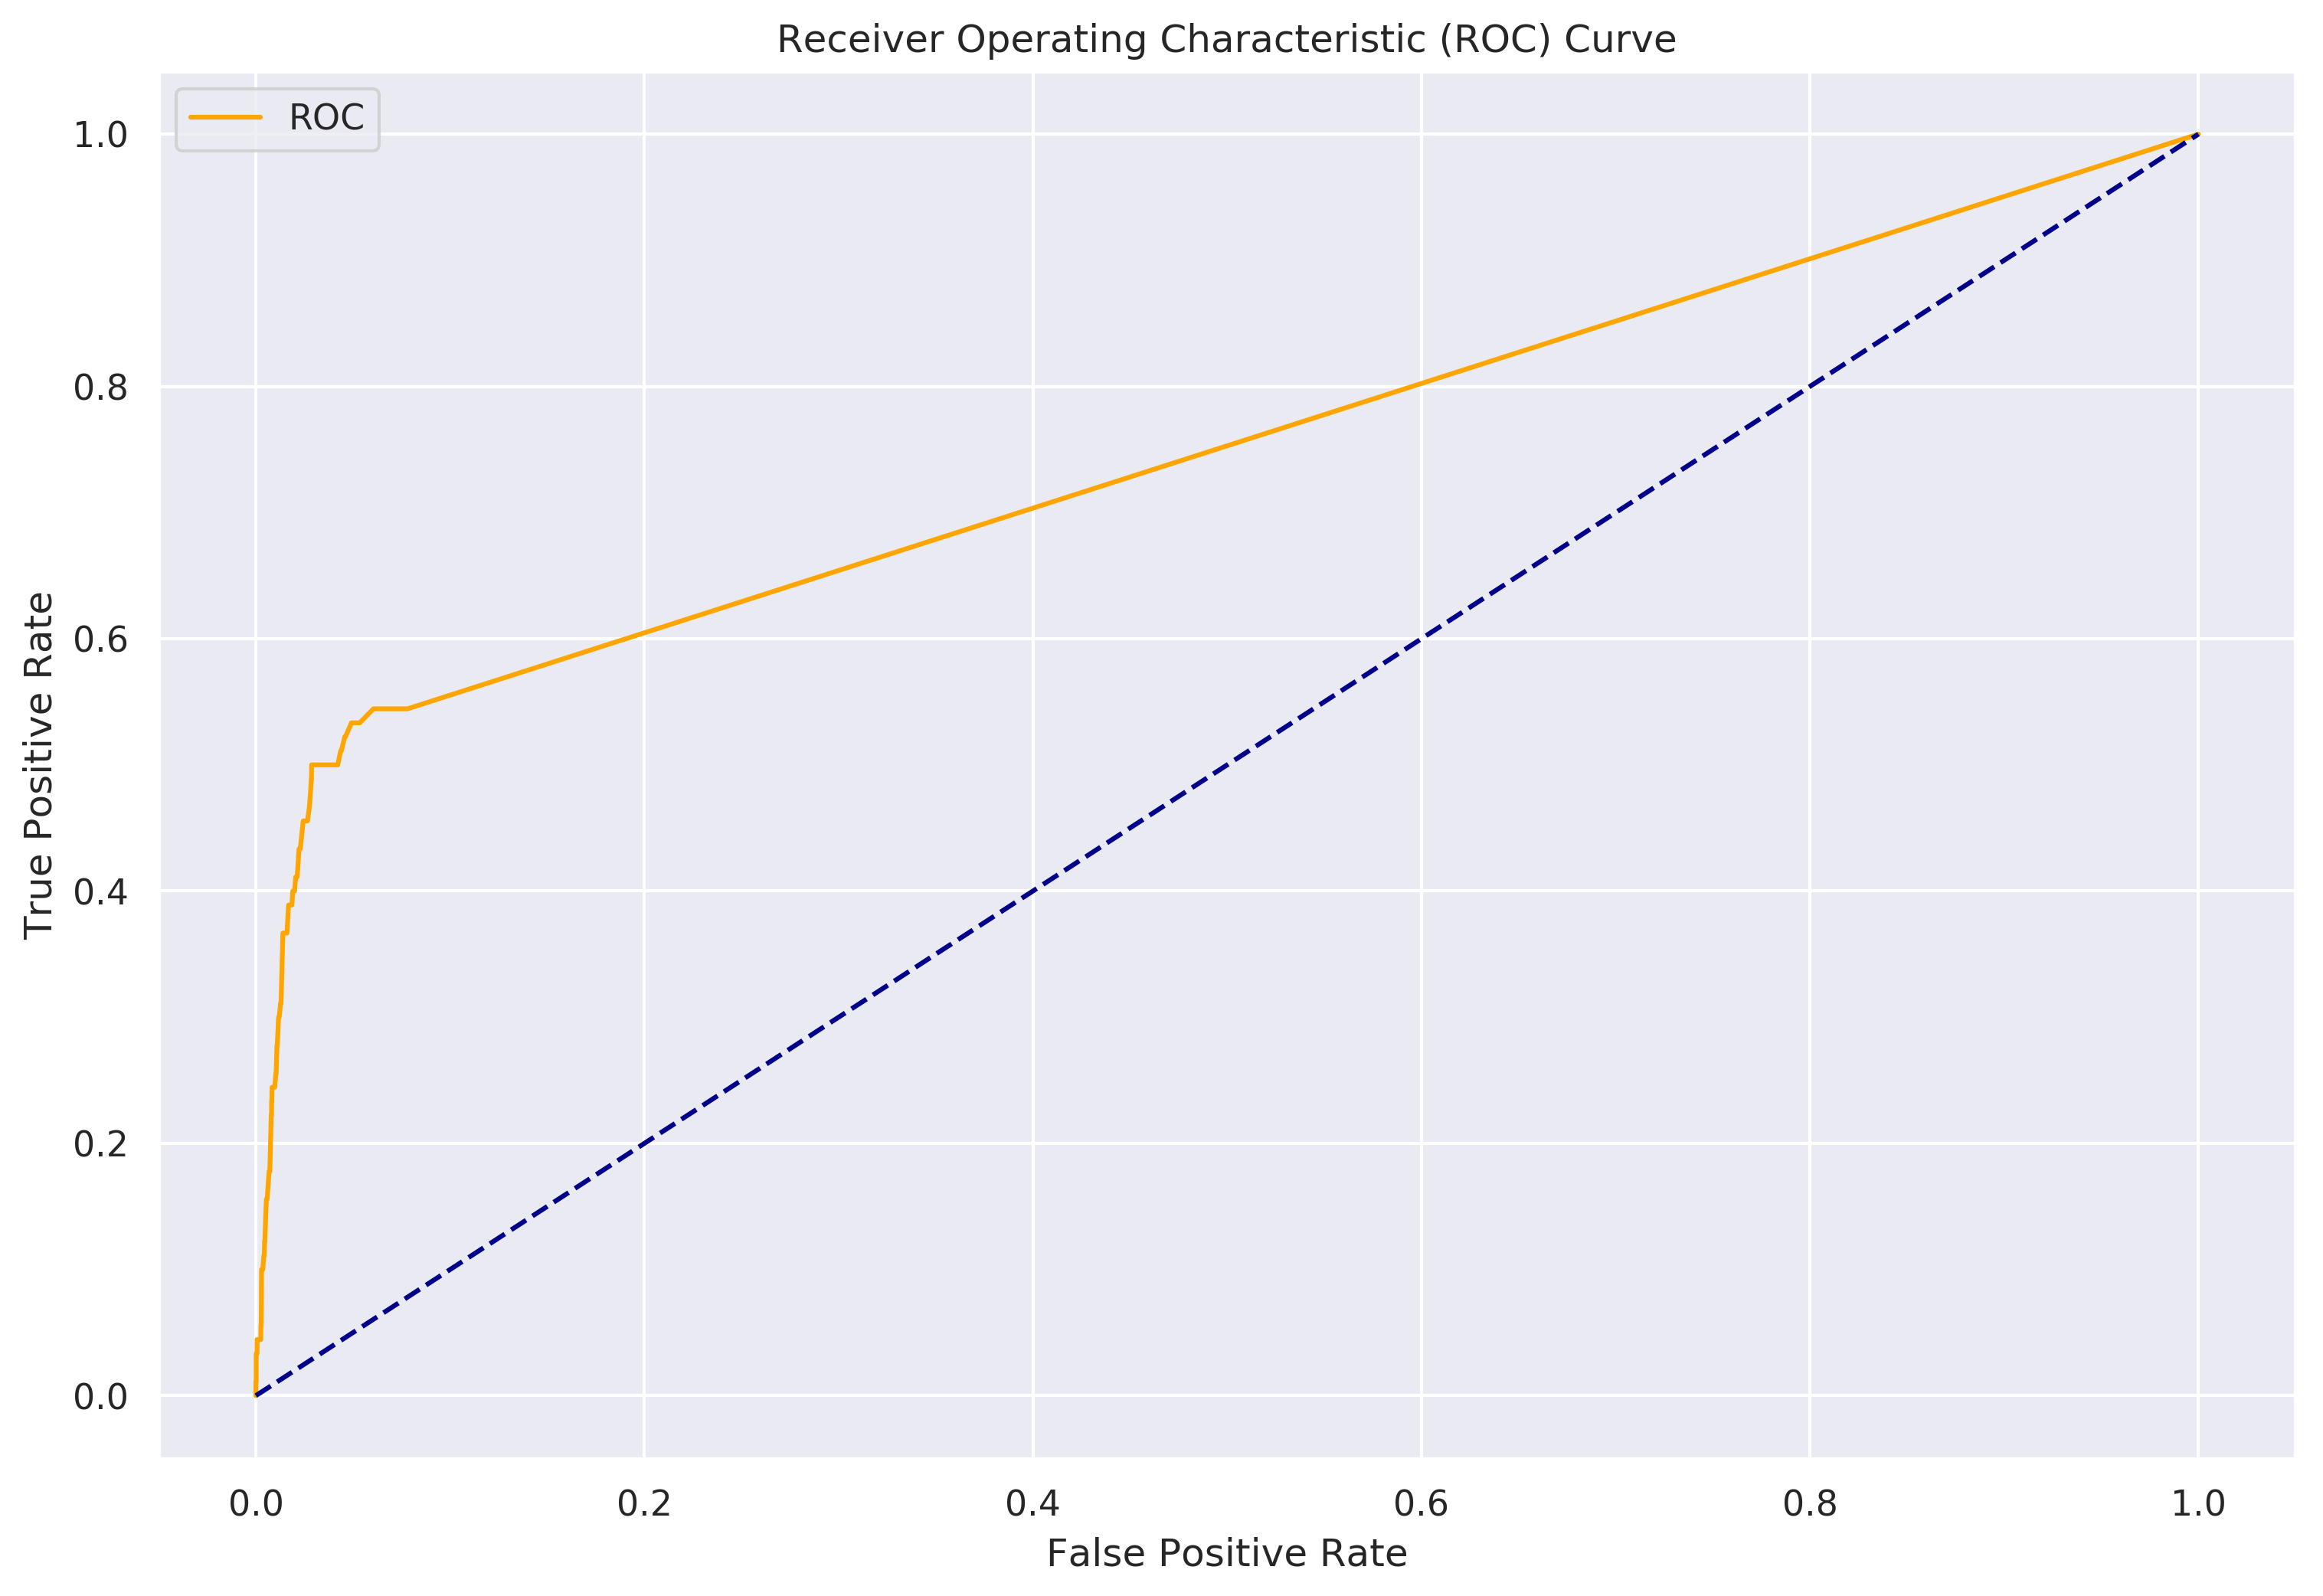

In [39]:
nummerical_cols = ['amount_convert', 
                       'currencycode', 
                       'spent_in_issue_country', 
                       'cvcresponsecode']
x_train = np.asarray(df_remapped[nummerical_cols])
y_train = df_remapped['is_fraud']

train_features, test_features, train_labels, test_labels = split_data(df_exp, df['is_fraud'])
predictions, errors = random_forrest(train_features, test_features, train_labels, test_labels)

print(f"train_features: {len(train_features)}")
print(f"test_features: {len(test_features)}")
print(f"train_labels: {len(train_labels)}")
print(f"test_labels: {len(test_labels)}")

auc = roc_auc_score(test_labels, predictions)  
print('AUC: %.2f' % auc)  
fpr, tpr, thresholds = roc_curve(test_labels, predictions)  

i = 0
false_negs = 0
false_pos = 0
true_pos
for p in predictions:
    if (p < 0.5 and test_labels[i]):
#         print(f"False negative pred: {p}, val: {test_labels[i]}")
        false_negs += 1
    if (p > 0.5 and not test_labels[i]):
#         print(f"False positive pred: {p}, val: {test_labels[i]}")
        false_pos += 1
    if (p > 0.5 and test_labels[i]):
        true_pos += 1
    i += 1
    
print(f"false positives: {false_pos}, false negatives: {false_negs}")

plot_roc_curve(fpr, tpr).show()
# print(np.asarray(y_train2))


In [78]:
train_features, test_features, train_labels, test_labels = split_data(X_train, y_train)
X_train, y_train = apply_smote(cols, df_exp, fraud_rows)
predictions, errors = random_forrest(train_features, test_features, train_labels, test_labels)

[236691 236691]


KeyboardInterrupt: 

In [87]:
df_exp = df.drop(["bookingdate", 
                  "creationdate", 
                  "simple_journal", 
                  "mail_id", 
                  "ip_id", 
                  "card_id",
                  "is_fraud",
                  "txid",
                  "index",
                  "Unnamed: 0"], axis = 1)
cols = list(df_exp.columns)[3:]
cols


177777
59259


## Logistic regression


In [90]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

train_features, test_features, train_labels, test_labels = split_data(df_exp, df['is_fraud'])
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

NameError: name 'X' is not defined